## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable

In [2]:
DATASETS_FOLDER = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Final_Outputs/"

### Showcase Run

In [3]:
unop_univariate_baseline_true = np.squeeze(np.load(DATASETS_FOLDER+"unop_univariate_baseline_true_y.npy"))
unop_univariate_baseline_predicted = np.load(DATASETS_FOLDER+"unop_univariate_baseline_predicted_y.npy")

unop_univariate_multiOne_true = np.squeeze(np.load(DATASETS_FOLDER+"unop_univariate_multiOne_true_y.npy"))
unop_univariate_multiOne_predicted = np.load(DATASETS_FOLDER+"unop_univariate_multiOne_predicted_y.npy")

In [4]:
unop_univariate_baseline_residuals = unop_univariate_baseline_true - unop_univariate_baseline_predicted
unop_univariate_baseline_residuals = np.sum(unop_univariate_baseline_residuals, axis=1)

unop_univariate_multiOne_residuals = unop_univariate_multiOne_true - unop_univariate_multiOne_predicted
unop_univariate_multiOne_residuals = np.sum(unop_univariate_multiOne_residuals, axis=1)

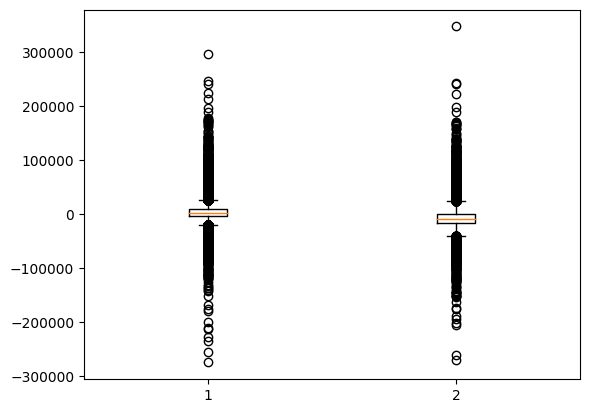

In [5]:
unop_univariate_baseline_boxplot = plt.boxplot([unop_univariate_baseline_residuals, unop_univariate_multiOne_residuals])

In [6]:
unop_univariate_baseline_var = np.var(unop_univariate_baseline_residuals)
print("Baseline Var", unop_univariate_baseline_var)
unop_univariate_multiOne_var = np.var(unop_univariate_multiOne_residuals)
print("MultiOne Var", unop_univariate_multiOne_var)

Baseline Var 424398433.5625493
MultiOne Var 448750788.617325


## Defining Analysis Functions

In [7]:
def import_data(model_name="univariate_baseline"):
    true = np.squeeze(np.load(DATASETS_FOLDER+model_name+"_true_y.npy"))
    predicted = np.load(DATASETS_FOLDER+model_name+"_predicted_y.npy")
    return true, predicted

In [22]:
def compute_residuals(true, pred):
    residuals = np.sum(true-pred, axis=1)
    # max_diff_index = np.argmax(residuals)
    # print("LARGEST RESIDUAL True", true[max_diff_index])
    # print("LARGEST RESIDUAL Pred", pred[max_diff_index])
    # min_diff_index = np.argmin(residuals)
    # print("SMALLEST RESIDUAL True", true[min_diff_index])
    # print("SMALLEST RESIDUAL Pred", pred[min_diff_index])
    return residuals

In [9]:
def generate_boxplot(datasets=[],title="DEFAULT", ylab="Download Bitrate",xlab=[],
                      output_folder="C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Images/"):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel(ylab)
    ax.boxplot(datasets, labels=xlab)
    plt.savefig(output_folder+title+".png", dpi=320)

In [10]:
def get_variance(data):
    return np.var(data)

In [11]:
def get_std(data):
    return np.std(data)

In [23]:
def carry_out_analysis(prefix="unop_univariate", title_prefix="Unoptimised Univariate"):
    for test_set in ["", "low", "medium", "high"]:
        all_residuals = []
        xlabels = []
        table = PrettyTable(["Model", "Variance", "Standard Dev"])
        for model in ["baseline", "multiOne", "multiAll"]:
            # print("\n=============\n",model, test_set,"\n=============\n")
            if not test_set:
                true, pred = import_data(prefix+"_{}".format(model))
            else:
                if model == "multiAll":
                    true, pred = import_data(prefix+"_{}_{}".format("multiOne", test_set))
                else:
                    true, pred = import_data(prefix+"_{}_{}".format(model, test_set))
            residuals = compute_residuals(true, pred)
            all_residuals.append(residuals)
            xlabels.append(model)
            var = get_variance(residuals)
            std = get_std(residuals)
            table.add_row([model, var, std])
        box_title = title_prefix + " {}".format(test_set.capitalize())
        if not test_set:
            box_title = title_prefix
        generate_boxplot(all_residuals, title=box_title, xlab=xlabels)
        print(box_title)
        print(table)
        print("\n\n")

All Network Features
+----------+--------------------+--------------------+
|  Model   |      Variance      |    Standard Dev    |
+----------+--------------------+--------------------+
| baseline | 501206290.81489336 | 22387.637008288602 |
| multiOne | 465285111.75605434 | 21570.46851035124  |
| multiAll | 465872521.2483526  | 21584.080273394848 |
+----------+--------------------+--------------------+



All Network Features Low
+----------+--------------------+-------------------+
|  Model   |      Variance      |    Standard Dev   |
+----------+--------------------+-------------------+
| baseline | 30680815.40254556  | 5539.026575360111 |
| multiOne | 2770158.0731134536 | 1664.379185496338 |
| multiAll | 2770158.0731134536 | 1664.379185496338 |
+----------+--------------------+-------------------+



All Network Features Medium
+----------+-------------------+-------------------+
|  Model   |      Variance     |    Standard Dev   |
+----------+-------------------+-------------------

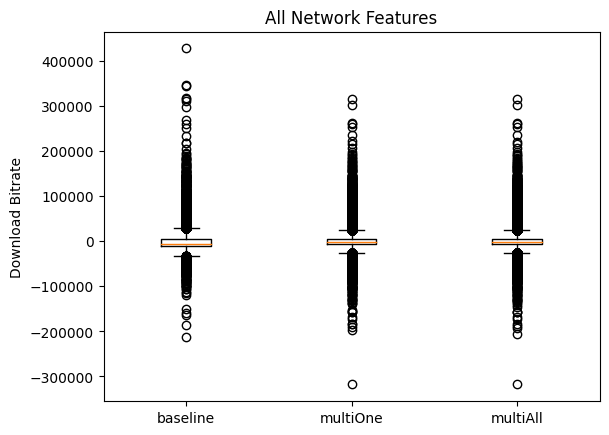

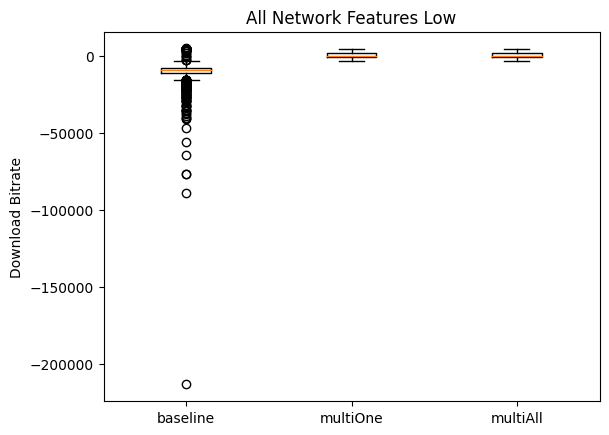

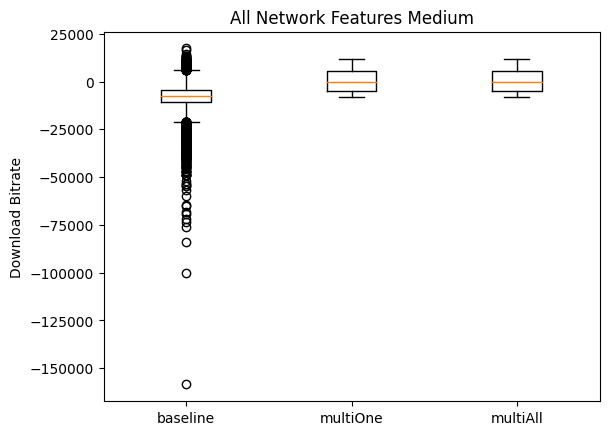

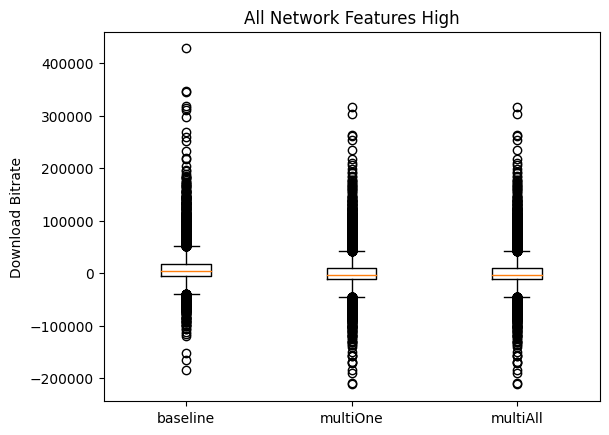

In [24]:
carry_out_analysis(prefix="all_network", title_prefix="All Network Features")

Univariate
+----------+-------------------+--------------------+
|  Model   |      Variance     |    Standard Dev    |
+----------+-------------------+--------------------+
| baseline | 461499333.0074869 | 21482.53553488244  |
| multiOne | 494570067.7707134 | 22238.931354062708 |
| multiAll | 495505895.9224883 | 22259.96172329342  |
+----------+-------------------+--------------------+



Univariate Low
+----------+--------------------+--------------------+
|  Model   |      Variance      |    Standard Dev    |
+----------+--------------------+--------------------+
| baseline | 40517128.02936001  | 6365.306593508282  |
| multiOne | 2585980.4655249347 | 1608.0984004484721 |
| multiAll | 2585980.4655249347 | 1608.0984004484721 |
+----------+--------------------+--------------------+



Univariate Medium
+----------+--------------------+-------------------+
|  Model   |      Variance      |    Standard Dev   |
+----------+--------------------+-------------------+
| baseline | 103019687.28

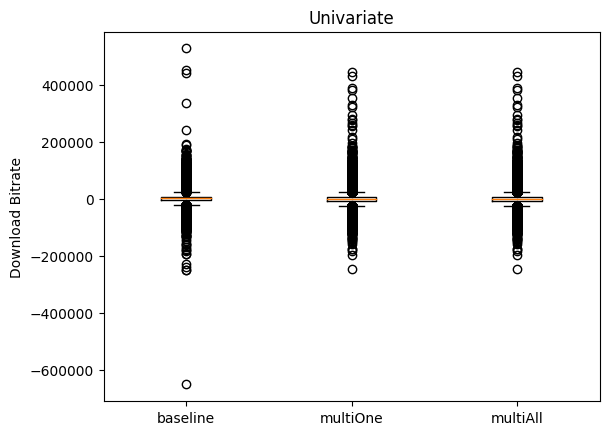

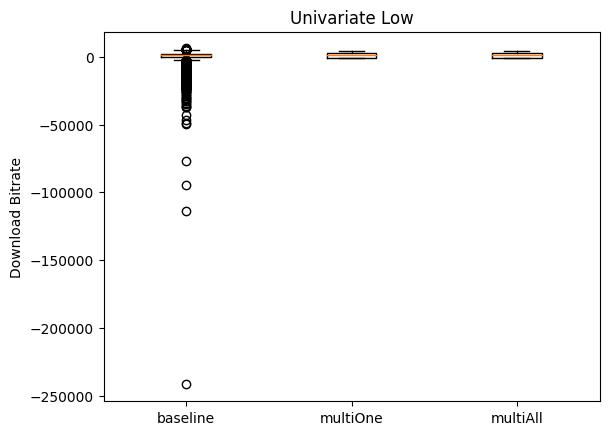

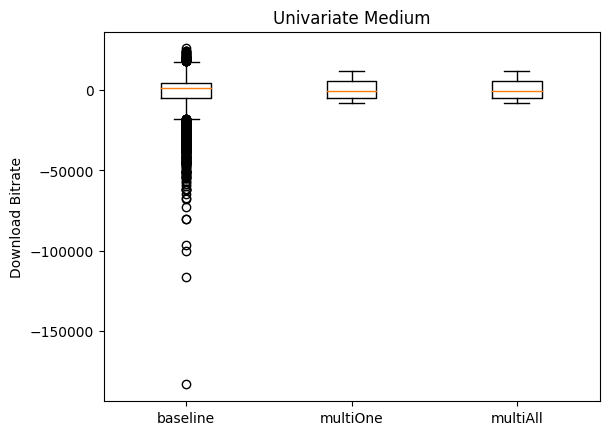

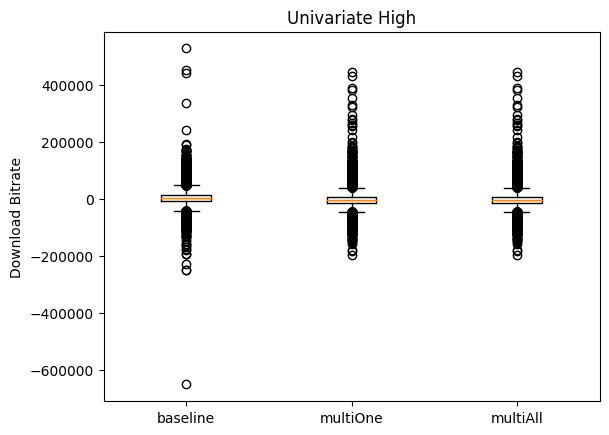

In [25]:
carry_out_analysis("univariate", "Univariate")

In [42]:
true, pred = import_data("unop_all_network_multiOne_low")

In [44]:
print(true[0])
print(pred[0])

[ 458. 1588.  145. 1319.  380.]
[4493.73277009 4670.10841024 5009.12997133 4946.02234918 4935.22048175]


In [41]:
true2, pred2 = import_data("unop_all_network_multiOne_medium")

In [43]:
print(true2[2])
print(pred2[2])

[4126. 2762. 3008. 2303. 1342.]
[14581.26955077 14845.64429909 14707.0076336  14523.93847257
 14790.32346234]
